In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import scipy

In [2]:
def N_avg(a, N=7):
    # weekly avg into the past, shorten a
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

def N_avg_hard(a, N=3):
    # hard edged rolling avg, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    b[:] = np.nan
    for i in range(N,len(a)-N,1):
        b[i] = np.mean(a[i-N:i+N])
    return b

def N_avg_soft(a, N=3):
    # soft edged rolling avg, preseve len a 
    b = np.zeros(len(a))
    for i in range(len(a)):
        l = max(0,i-N)
        r = min(i+N+1, len(a))
        b[i] = np.mean(a[l:r])
    return b

def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

In [3]:
# download api data for England
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_england = pd.DataFrame(response['body'])
df_england['dateTime'] = pd.to_datetime(df_england['date'])
df_england.sort_values(by=['dateTime'], inplace=True)
df_england.dropna(inplace=True)

top_date = sorted(list(set(df_england.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-27


In [4]:
# download api data for regions 
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=region&metric=newCasesBySpecimenDate&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions_cases = pd.DataFrame(response['body'])
df_regions_cases['dateTime'] = pd.to_datetime(df_regions_cases['date'])
df_regions_cases.sort_values(by=['dateTime'], inplace=True)
df_regions_cases.dropna(inplace=True)

top_date_cases = sorted(list(set(df_regions_cases.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date_cases)

req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nhsRegion&metric=newAdmissions&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions_nhs = pd.DataFrame(response['body'])
df_regions_nhs['dateTime'] = pd.to_datetime(df_regions_nhs['date'])
df_regions_nhs.sort_values(by=['dateTime'], inplace=True)
df_regions_nhs.dropna(inplace=True)

top_date_nhs = sorted(list(set(df_regions_nhs.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date_nhs)

top_date = min(top_date_cases, top_date_nhs)

2021-12-28
2021-12-27


In [5]:
# input defs
train_in_stream = []
train_out_stream = []
dates_train = []
test_in_stream = []
test_out_stream = []
dates_test = []

in_event = ""
out_event = ""
geographical_context = ""

train_start_date = "2020-11-15" 
train_end_date = "2021-03-01"
test_start_date = "2021-10-15"
test_end_date = top_date

#train_start_date = "2021-07-01" 
#train_end_date = "2021-12-01"
#test_start_date = "2021-10-01"
#test_end_date = top_date

In [6]:
# set data: England +ve tests -> hosp admissions
df = df_england
train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newCasesBySpecimenDate.to_list(), dtype=float)
train_out_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
test_in_stream = np.array(test_df.newCasesBySpecimenDate.to_list(), dtype=float)
test_out_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "+ve test"
out_event = "admitted"
geographical_context = "England"

In [7]:
# set data: Regional +ve tests -> hosp admissions
region = "London"
df_c = df_regions_cases[df_regions_cases.areaName==region]
df_n = df_regions_nhs[df_regions_nhs.areaName==region]

train_df_c = df_c[(df_c.dateTime >= train_start_date) & (df_c.dateTime <= train_end_date)]
train_df_n = df_n[(df_n.dateTime >= train_start_date) & (df_n.dateTime <= train_end_date)]
test_df_c = df_c[(df_c.dateTime >= test_start_date) & (df_c.dateTime <= test_end_date)]
test_df_n = df_n[(df_n.dateTime >= test_start_date) & (df_n.dateTime <= test_end_date)]

train_in_stream = np.array(train_df_c.newCasesBySpecimenDate.to_list(), dtype=float)
train_out_stream = np.array(train_df_n.newAdmissions.to_list(), dtype=float)
test_in_stream = np.array(test_df_c.newCasesBySpecimenDate.to_list(), dtype=float)
test_out_stream = np.array(test_df_n.newAdmissions.to_list(), dtype=float)
dates_train = sorted(list(set(train_df_c.dateTime.to_list())))
dates_test = sorted(list(set(test_df_c.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "+ve test"
out_event = "admitted"
geographical_context = region

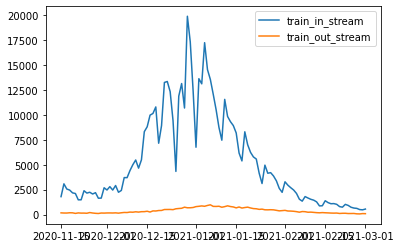

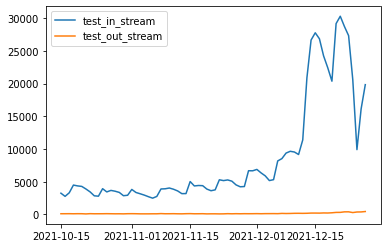

In [8]:
plt.clf()
plt.plot(dates_train, train_in_stream, label="train_in_stream")
plt.plot(dates_train, train_out_stream, label="train_out_stream")
plt.legend()
plt.show()
plt.clf()
plt.plot(dates_test, test_in_stream, label="test_in_stream")
plt.plot(dates_test, test_out_stream, label="test_out_stream")
plt.legend()
plt.show()

In [9]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=train_in_stream, out_stream=train_out_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [10]:
n_dim = 40
n_particles = 1000

x_max = 0.03*np.ones(n_dim)
x_min = -0.005*np.ones(n_dim)
options = {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([np.zeros(n_dim) for i in range(n_particles)])

_minimizers = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    _minimizers.append(pos)
minimizers = np.array(_minimizers)

2021-12-30 15:17:21,379 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=22.9
2021-12-30 15:17:26,547 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 22.86983506555581, best pos: [ 1.86683535e-03  5.35989023e-03  5.55823894e-03  3.14385099e-03
  1.07445231e-03  9.50671580e-03  9.32419326e-03  5.70658236e-03
  7.79696544e-06  6.04238169e-03  3.28146455e-03  1.18892969e-03
  3.88596943e-04  1.81435437e-03  3.60008255e-03 -5.82145688e-04
  3.58629973e-03  3.37009662e-03 -1.15185706e-03  9.42807125e-04
  8.69051111e-04  1.06293712e-03 -1.60882771e-03 -3.35362738e-04
 -2.27348400e-03 -5.37843230e-04 -1.94422477e-03  3.41501835e-03
 -1.13956870e-04  2.27514018e-03  8.44073693e-04  1.40597384e-03
 -7.95628508e-04  2.95459019e-03  1.51728540e-03  9.05789926e-05
 -2.46391604e-04 -1.21317097e-03 -1.72537675e-04  9.48360749e-04]
2021-12-30 15:17:26,554 - 

2021-12-30 15:18:39,726 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=21.8
2021-12-30 15:18:50,316 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 21.84432883676475, best pos: [ 5.29484183e-03  3.08475279e-03  2.36566965e-03  9.38580591e-03
  5.01293129e-03  9.67066155e-03  3.39226121e-03  4.32409411e-03
 -1.15088529e-03  1.17874052e-03  4.04749172e-03 -2.65616820e-04
  8.78980043e-05  1.67632701e-03  1.18640078e-02  6.17823015e-04
  2.76116322e-03  1.94589568e-03 -5.27552769e-04  6.30022391e-04
  2.65907176e-04  2.04247115e-04 -2.85661953e-04 -2.47894999e-03
  8.40909724e-04 -1.77113075e-03  3.59179611e-03  7.73429238e-04
  3.52697194e-04  2.68027455e-03 -9.25002741e-05 -5.49357205e-04
 -5.07916101e-04  3.87926424e-04  4.54227666e-04 -1.45566366e-03
  2.03879887e-03  8.66367149e-07  1.98832255e-04  6.73745922e-04]
2021-12-30 15:18:50,326 - 

2021-12-30 15:20:08,771 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=23.4
2021-12-30 15:20:17,592 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 23.415747654334034, best pos: [ 4.44059358e-03  4.43005125e-03  6.14038273e-04  6.05789940e-03
  7.33845083e-04  1.43753746e-02  2.29481188e-03  8.41993917e-03
  1.24692055e-03  4.01419470e-03  2.95626168e-03 -1.23214592e-03
  1.50426546e-03  4.09518766e-03  3.21617784e-03 -5.84810705e-04
  3.94984160e-03  2.83955495e-03  1.69179423e-03 -2.56106456e-03
 -7.06605530e-04  1.45493396e-03  4.89487891e-04 -3.69222897e-04
 -5.47189297e-04 -5.92635262e-04  1.28281877e-03  5.32666123e-03
 -7.10534637e-04 -6.29670915e-04 -1.13460487e-03  3.62367676e-04
  4.60455697e-04 -7.15722825e-04 -4.11511757e-04  2.31830896e-03
  3.79250497e-04  1.69171144e-03 -4.71541590e-04  3.50665824e-05]
2021-12-30 15:20:17,608 -

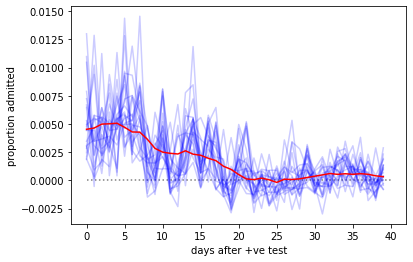

<Figure size 432x288 with 0 Axes>

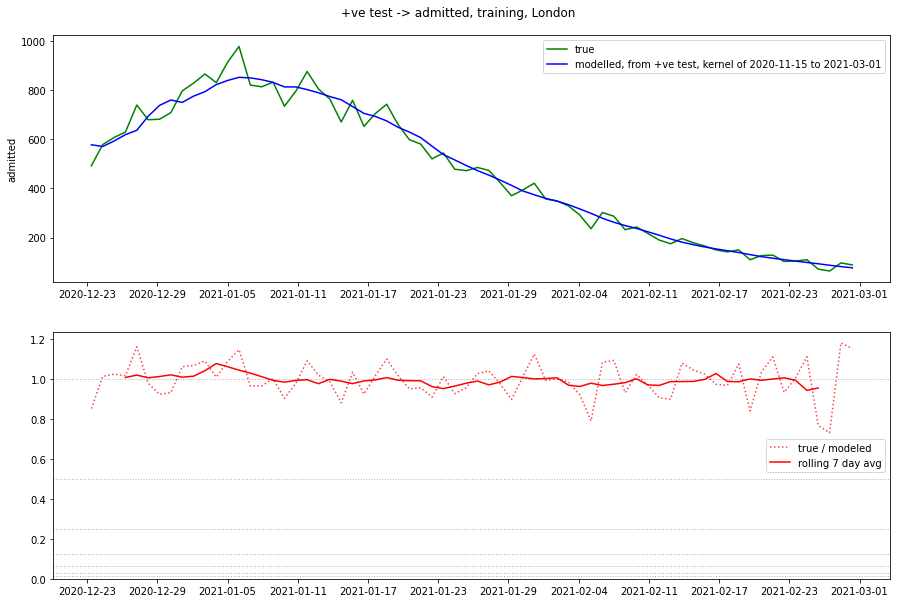

<Figure size 432x288 with 0 Axes>

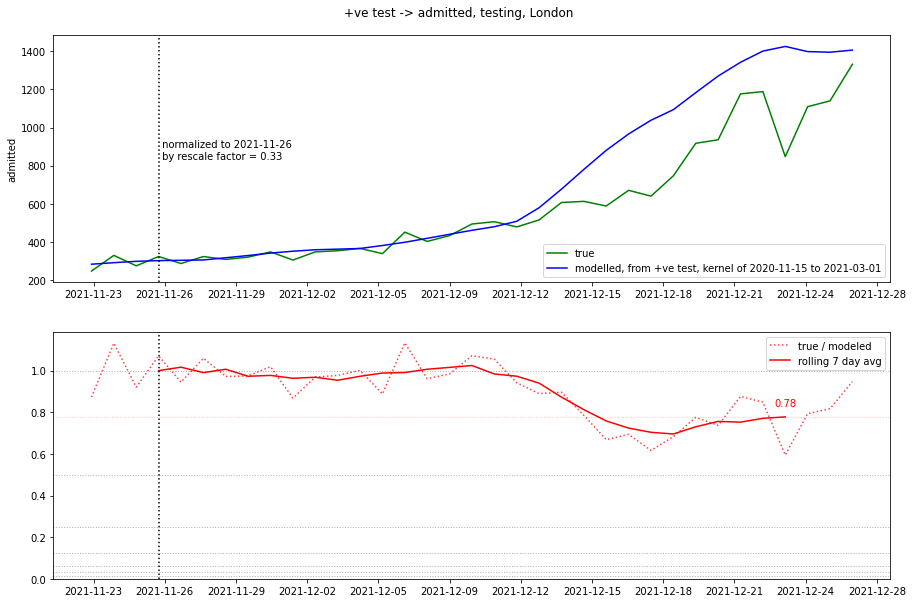

In [52]:
# show kernel
plt.clf()
z = list(range(len(pos)))
for y in minimizers:
    plt.plot(z, y, color="blue", alpha=0.2)
avg_minimizer = []
for i in range(len(minimizers[0])):
    avg_minimizer.append(np.mean(minimizers[:,i]))
avg_minimizer = np.array(avg_minimizer)
avg_minimizer = N_avg_soft(avg_minimizer, 3) 
plt.plot(z, avg_minimizer, color="red", alpha=1)
plt.xlabel("days after %s" % in_event)
plt.ylabel("proportion %s" % out_event)
plt.hlines(0, 0,len(z), ls="dotted", alpha=0.5, color="black")
plt.savefig("%s__%s__kernel__%s.png" % (in_event, out_event, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#print("mass: %.2f" % np.sum(avg_minimizer))

# show fit to training & testing
def make_graph(dates, kernel, in_stream, out_stream, test_train):
    plt.clf()
    assert(len(in_stream)==len(out_stream))
    assert(len(kernel)<=len(in_stream))
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    ax1,ax2 = axes   
    
    true, pred = _f(avg_minimizer, in_stream, out_stream) 
    x = dates[-len(true):]
    diff = true/pred
    avg_diff = N_avg_hard(diff, 3)
    rescale_factor = 1
    if test_train=="test":
        rescale_factor = avg_diff[np.isfinite(avg_diff)][0]
    
    ax1.plot(x, true/rescale_factor, color="green", label="true")
    modeled_label = "modelled, from %s, kernel of %s to %s" % (in_event, train_start_date, train_end_date)
    ax1.plot(x, pred, color="blue", label=modeled_label)
    ax1.set_ylabel("%s" % out_event)
    ax1.legend()
    n_marks = 11
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    
    ax2.plot(x, diff/rescale_factor, color="red", alpha=0.75, ls="dotted", label="true / modeled")
    ax2.plot(x, avg_diff/rescale_factor, color="red", label="rolling 7 day avg")
    for i in range(7):
        ax2.axhline(y=2**(-i), ls="dotted", lw=1, alpha=0.3, color="black")        
    ax2.set_ylim(0,None)
    ax2.legend()
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))

    if test_train=="test":
        end_level = avg_diff[np.isfinite(avg_diff)][-1]
        ax2.axvline(x=x[3], color="black", ls="dotted")
        ax1.axvline(x=x[3], color="black", ls="dotted")
        y_min,y_max = ax1.get_ylim()
        y_mid = (y_min+y_max)/2 
        ax1.text(x[3], y_mid, " normalized to %s\n by rescale factor = %.2f" % (x[3].strftime("%Y-%m-%d"), rescale_factor), ha="left")
        ax2.axhline(y=end_level/rescale_factor, color="red", alpha=0.25, ls="dotted", lw=1)
        ax2.text(x[-4], end_level/rescale_factor+0.05, "%.2f" % (end_level/rescale_factor), ha="center", color="red")    
    
    fig.suptitle("%s -> %s, %sing, %s" % (in_event, out_event, test_train, geographical_context), y=0.92)
    plt.savefig("%s__%s__%s__%s.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    
make_graph(dates_train, avg_minimizer, train_in_stream, train_out_stream, "train") 
make_graph(dates_test, avg_minimizer, test_in_stream, test_out_stream, "test") 




In [35]:
print(avg_minimizer)

[ 4.53260415e-03  4.64445959e-03  4.99207738e-03  5.01923684e-03
  5.07071815e-03  4.70930790e-03  4.29709663e-03  4.27856167e-03
  3.64313602e-03  2.83709115e-03  2.51032764e-03  2.40222826e-03
  2.34604140e-03  2.62762857e-03  2.32740965e-03  2.23082233e-03
  1.96263663e-03  1.75605865e-03  1.25621340e-03  9.77203319e-04
  5.18527469e-04  1.36039471e-04  7.50649299e-05  2.02944255e-04
  5.77281377e-05 -1.72736423e-04  1.09589334e-04  8.23654743e-05
  1.41905403e-04  2.61562608e-04  3.77233049e-04  4.91392784e-04
  6.13482049e-04  5.39363168e-04  5.92935603e-04  5.40596337e-04
  5.98621388e-04  5.45824838e-04  4.08708110e-04  3.32330704e-04]
